## 8. Error Analysis
This notebook is about Error analysis of the Random Forest model we built

In [2]:
## load modules
import sys
sys.path.append("..")
import pandas as pd
import numpy as np
import ast
import matplotlib.pyplot as plt
import seaborn as sns
from copy import deepcopy
from modeling.features import get_feature_combinations
from sklearn.svm import SVR
from lightgbm import LGBMRegressor 
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler
sns.set_theme()

In [3]:
# loading the cleaned dataset
data = pd.read_csv('../data/GEFCom2014Data/Wind/clean_data.csv', parse_dates=['TIMESTAMP'], index_col='TIMESTAMP')

In [4]:
# train-test-split and get features
data_train = data[:'2013-07-01 00:00:00']
data_test = data['2013-07-01 01:00:00':]
feature_dict = get_feature_combinations()

In [7]:
result_df = pd.DataFrame()
result_dict = {}
result_dict['RandomForestRegressor'] = pd.read_csv(f'../results/RandomForestRegressor.csv', index_col='ZONE')
result_dict['RandomForestRegressor']['ZONEID'] = range(1,11) 
result_df = result_df.append(result_dict['RandomForestRegressor'])

In [8]:

models_dict = {}
prediction_dict = {}
y_test_dict = {} 
X_test_dict = {}

df_results = pd.DataFrame()
df_model = result_dict['RandomForestRegressor']
models_dict['RandomForestRegressor'] = {}
prediction_dict['RandomForestRegressor'] = {}
X_test_dict['RandomForestRegressor'] = {}
y_test_dict['RandomForestRegressor'] = {}

for zone in df_model.ZONEID.unique():
    fc = df_model[df_model.ZONEID == zone]['FC'].values[0]
    
    data_train_zone = data_train[data_train.ZONEID == zone]
    data_test_zone = data_test[data_test.ZONEID == zone]

    X_train = data_train_zone[feature_dict[fc]]
    X_test = data_test_zone[feature_dict[fc]]
    X_test_dict['RandomForestRegressor'][zone] = X_test

    y_train = data_train_zone.TARGETVAR
    y_test = data_test_zone.TARGETVAR
    y_test_dict['RandomForestRegressor'][zone] = y_test.values

    best_params = df_model[df_model.ZONEID == zone]['BEST_PARAMS'].values[0]
    model = RandomForestRegressor().set_params(**ast.literal_eval(best_params))
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    y_pred = np.array([1 if value >= 1 else 0 if value <= 0 else value for value in y_pred])
    
    tmp_df = deepcopy(data_test_zone)
    tmp_df['MODEL'] = 'RandomForestRegressor'
    tmp_df['PRED'] = y_pred
    tmp_df['RESIDUAL'] = tmp_df.PRED - tmp_df.TARGETVAR

    df_results = df_results.append(tmp_df)
    
    prediction_dict['RandomForestRegressor'][zone] = y_pred
    models_dict['RandomForestRegressor'][zone] = deepcopy(model)


Plotting residuals for every Windfarm.

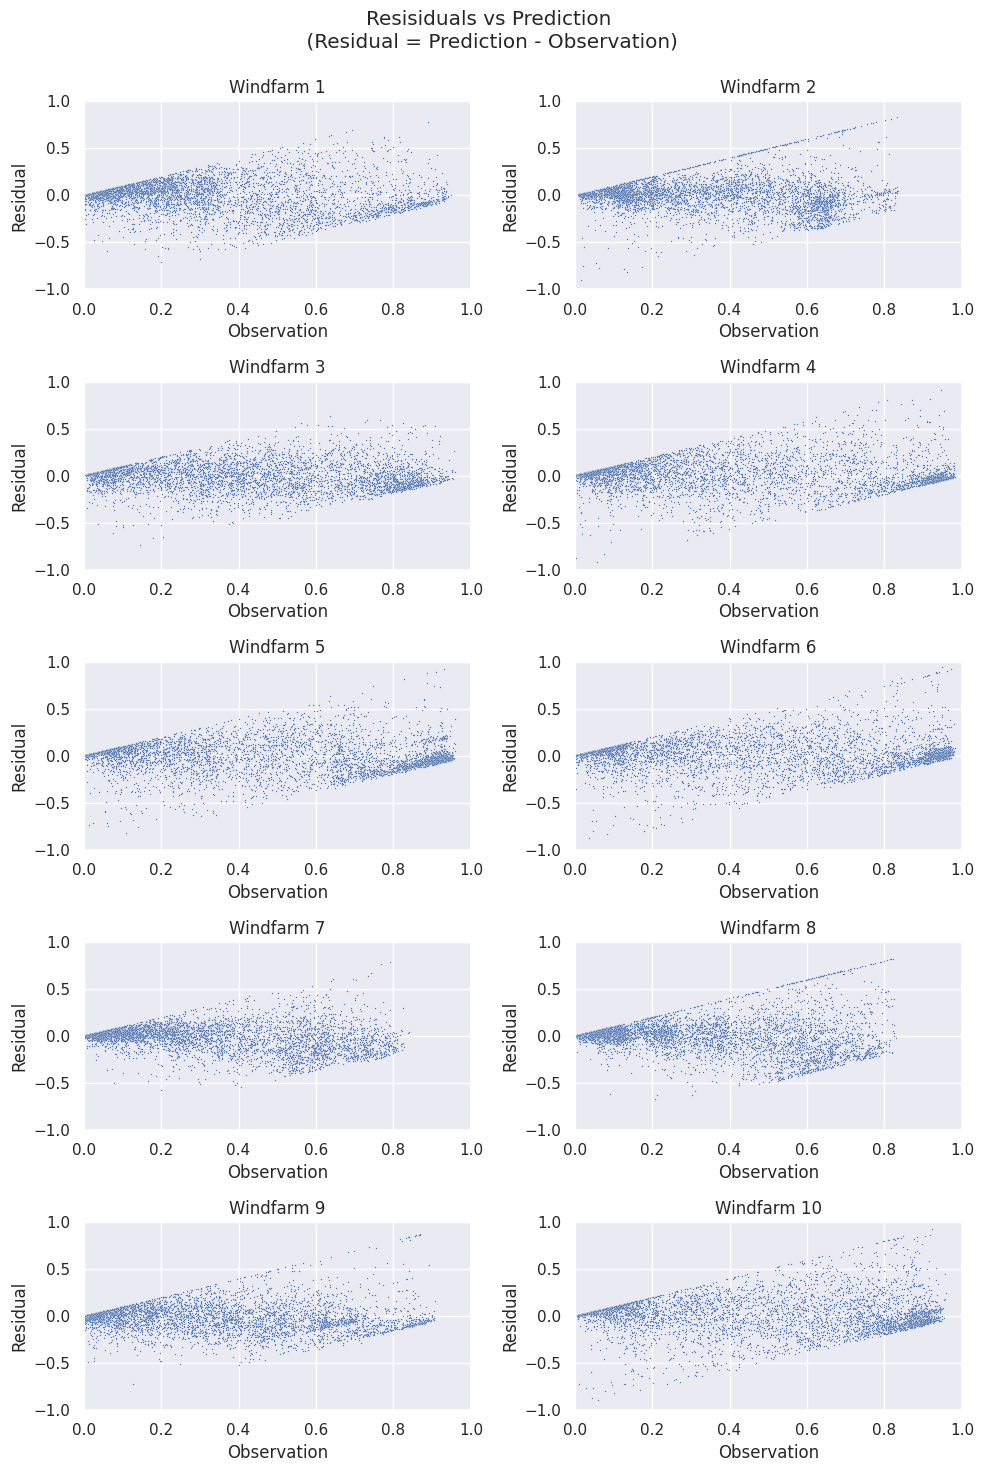

In [24]:

residuals_dict = {}

fig, axs = plt.subplots(nrows=5, ncols=2,figsize = (10,15), dpi = 100)
axs = axs.ravel()
fig.suptitle("Resisiduals vs Prediction \n (Residual = Prediction - Observation) \n" )
model = 'RandomForestRegressor'
residuals_dict[model] = {}
    
for zone in range(1,11):
    residuals_dict[model][zone] = prediction_dict[model][zone] - y_test_dict[model][zone]
    y = residuals_dict[model][zone]
    x = prediction_dict[model][zone]
    p = sns.scatterplot(x = x, y = y, s = 1, ax = axs[zone - 1])
    axs[zone - 1].set_title('Windfarm {}'.format(zone))
    axs[zone - 1].set_xlim([0,1])
    axs[zone - 1].set_ylim([-1,1])
    p.set(xlabel = "Observation", ylabel = "Residual")
fig.tight_layout()    

Plotting residuals aggregated over all wind farms.

Plotting averages of residuals.

In [13]:
# Defining bins for predicted wind energy production and predicted wind speed.

pred_bins = [round(x, 2) for x in np.arange(0, 1.01, 0.05)]
pred_labels = []
for i, bin_ in enumerate(pred_bins):
    if i > len(pred_bins) - 2:
        break
    pred_labels.append(f'{bin_:.2f}-{pred_bins[i + 1]:.2f}')

ws_bins = [round(x, 2) for x in np.arange(0, 25, 2)]
ws_labels = []
for i, bin_ in enumerate(ws_bins):
    if i > len(ws_bins) - 2:
        break
    ws_labels.append(f'{bin_}-{ws_bins[i + 1]}')

df_results['PRED_BIN'] = pd.cut(df_results['PRED'], bins = pred_bins, labels=pred_labels)
df_results['WS100_BIN'] = pd.cut(df_results['WS100'], bins = ws_bins, labels=ws_labels)

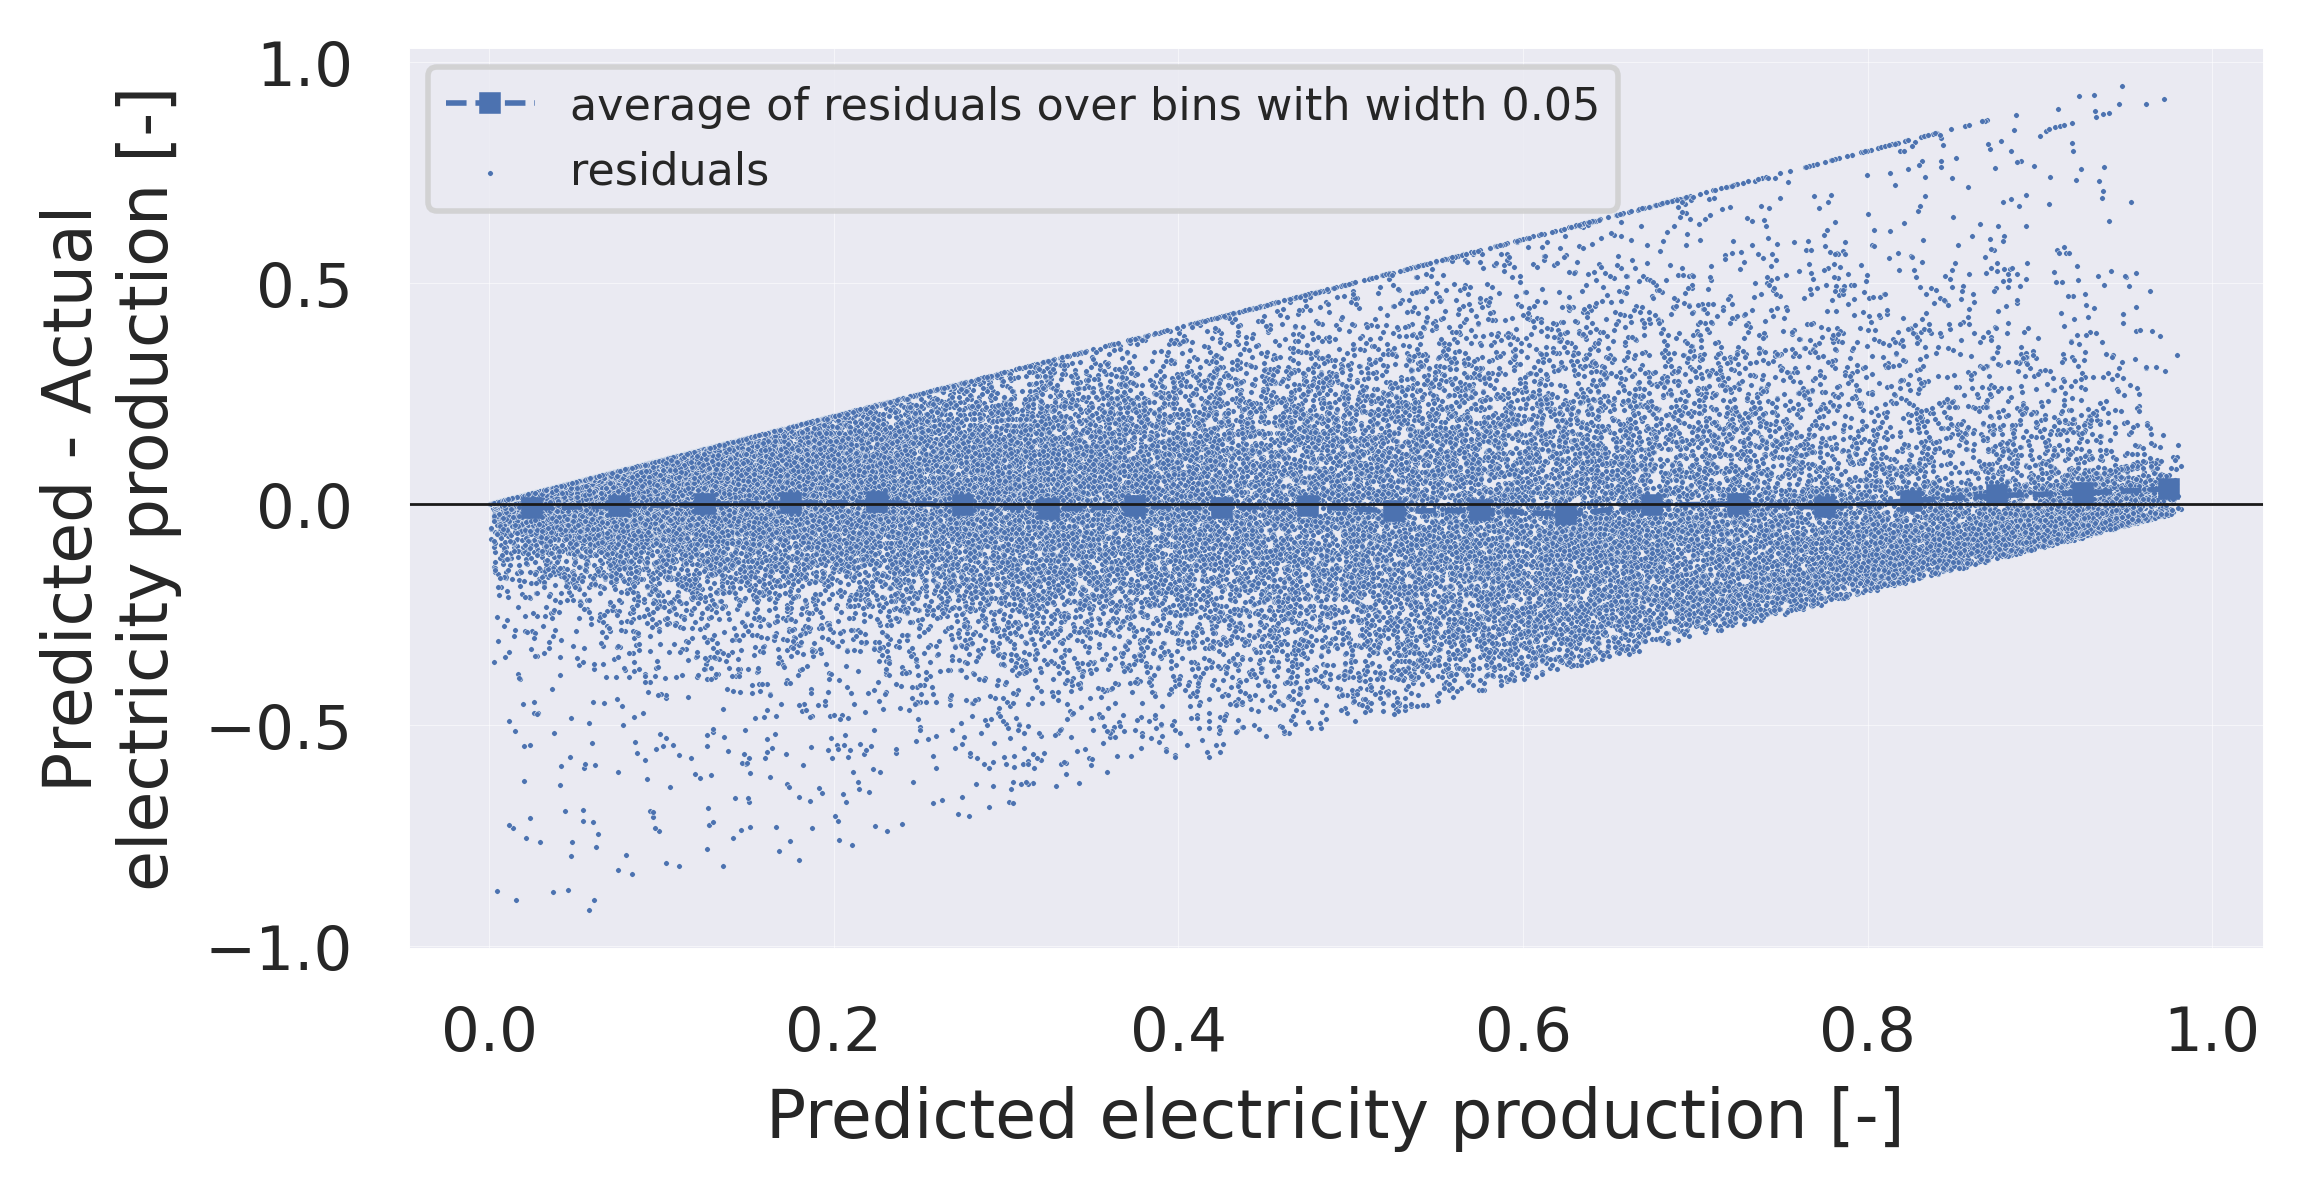

In [15]:
bias = df_results.groupby(by = 'PRED_BIN').mean()['RESIDUAL'] 
fig,ax = plt.subplots(dpi=400, figsize=(6,3))
ax.plot(np.arange(.025,1.00,.05), bias.values, linewidth=1, linestyle='--', marker='s', markersize=3, color='b', label='average of residuals over bins with width 0.05')
scatter = sns.scatterplot(data = df_results, x = 'PRED', y = 'RESIDUAL', s=1, label='residuals')
ax.grid(linewidth=.1)
ax.set_ylabel('Predicted - Actual\n electricity production [-]')
ax.set_xlabel('Predicted electricity production [-]')
ax.axhline(color = 'k', linewidth = 0.5)
ax.legend(fontsize=8);

Plotting residuals vs predicted windspeed at height 100 m aggregated over all windfarms-

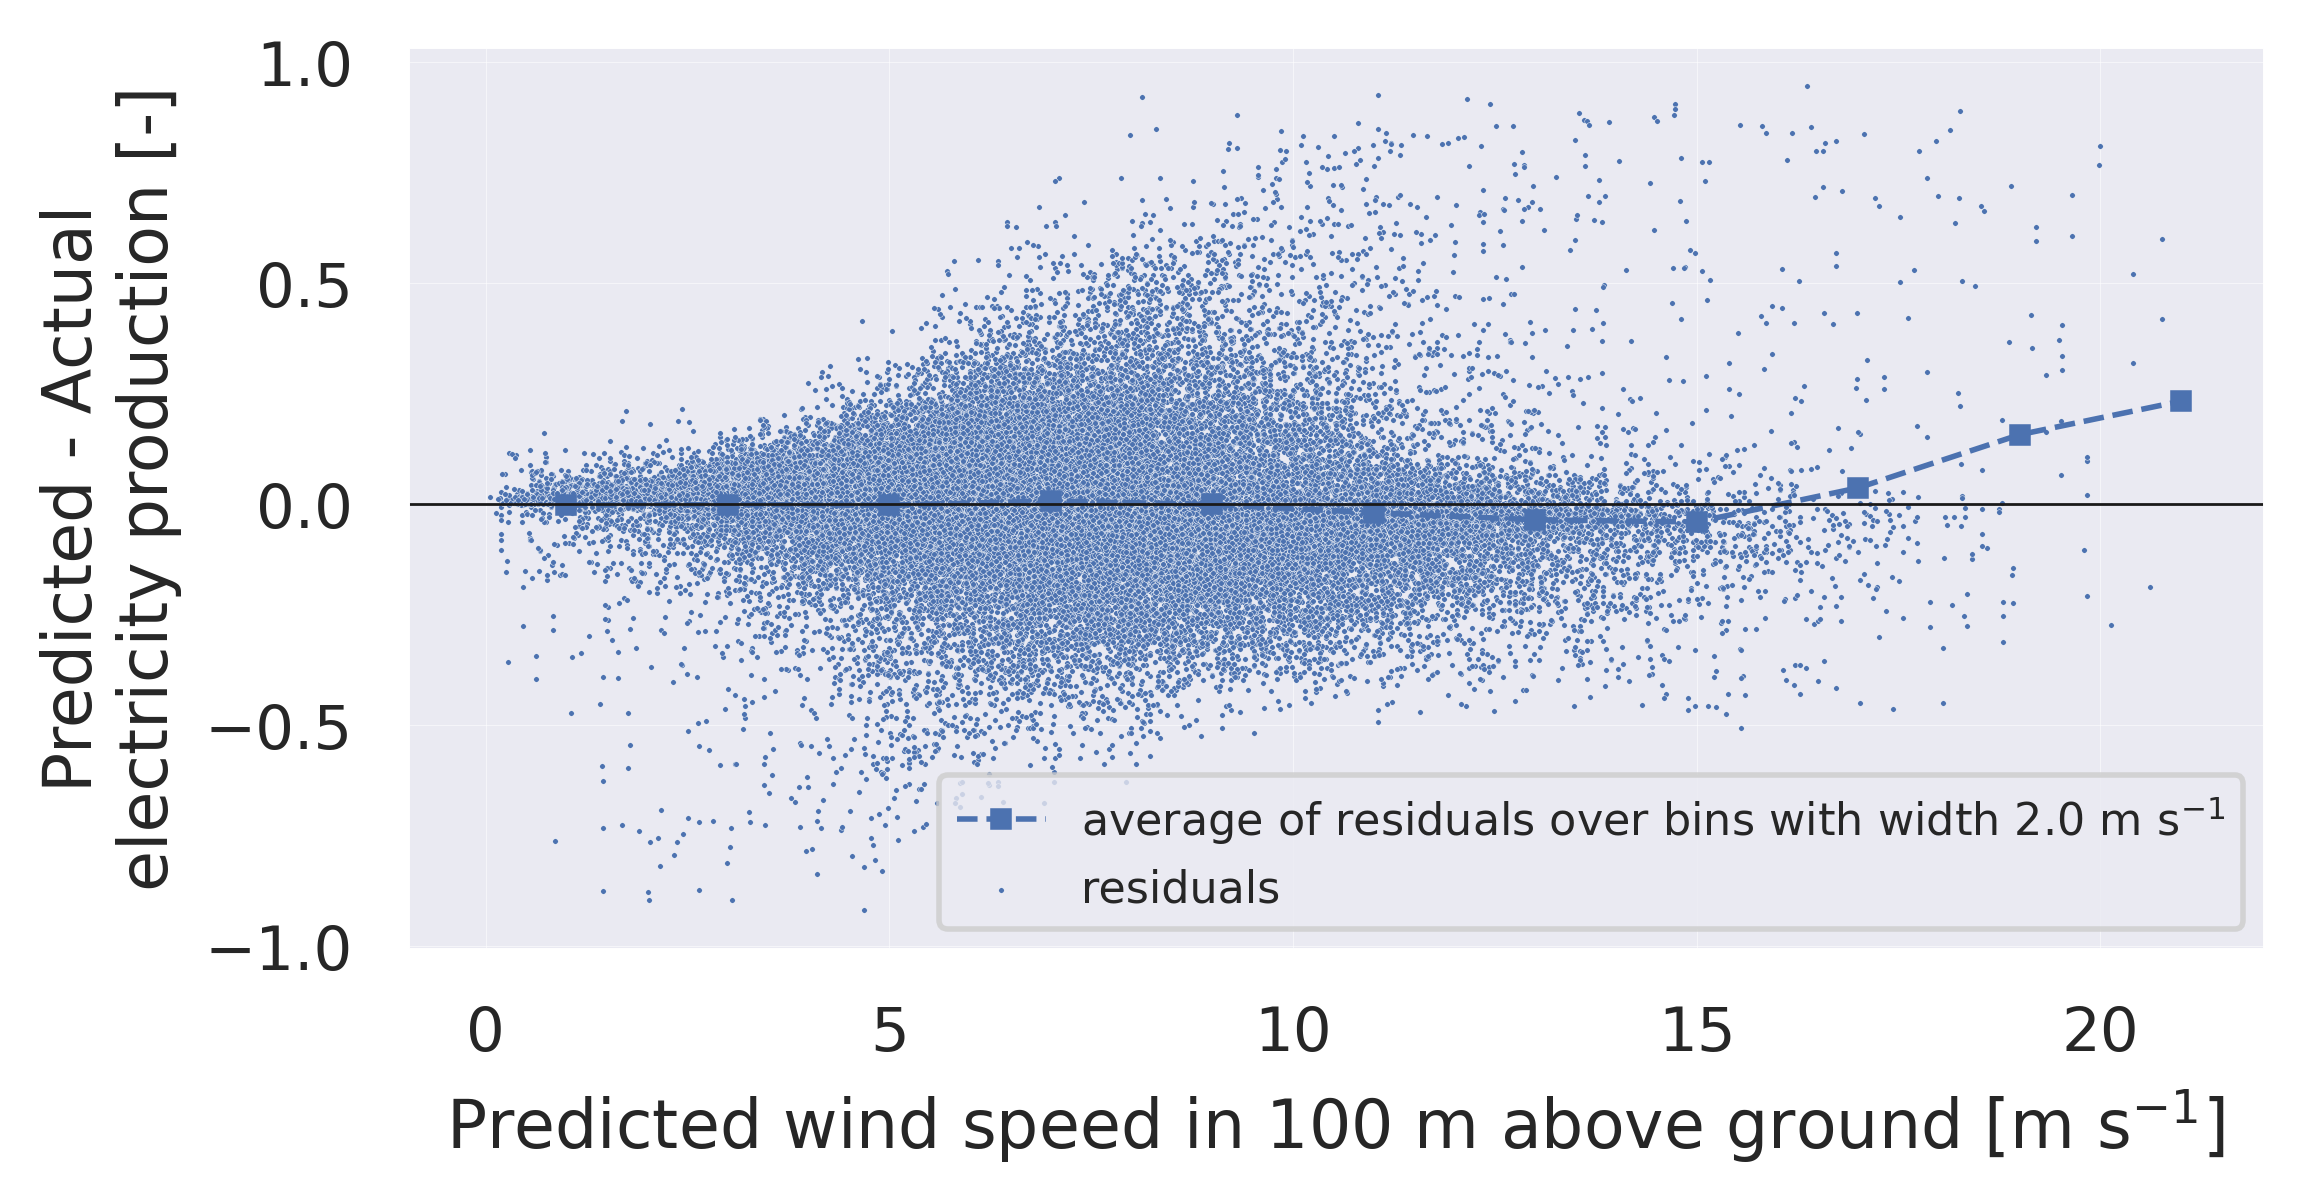

In [16]:
bias = df_results.groupby(by = 'WS100_BIN').mean()['RESIDUAL']

fig,ax = plt.subplots(dpi=400, figsize=(6,3))
ax.plot(np.arange(1,25,2), bias.values, linewidth=1, linestyle='--', marker='s', markersize=3, color='b', label='average of residuals over bins with width 2.0 $\mathregular{m\ s^{-1}}$')
scatter = sns.scatterplot(data = df_results, x = 'WS100', y = 'RESIDUAL', s=1, label='residuals')
ax.grid(linewidth=.1)
ax.set_ylabel('Predicted - Actual\n electricity production [-]');
ax.set_xlabel('Predicted wind speed in 100 m above ground [$\mathregular{m\ s^{-1}}$]');
ax.axhline(color = 'k', linewidth = 0.5)
ax.legend(fontsize=8);
fig.savefig('../images/Residuals-By-PredWS100_RandomForest_Aggregated.png')


The plot of the residuals look good. The residuals are randomly distributed. Except the zero values, as expected, see next plot.

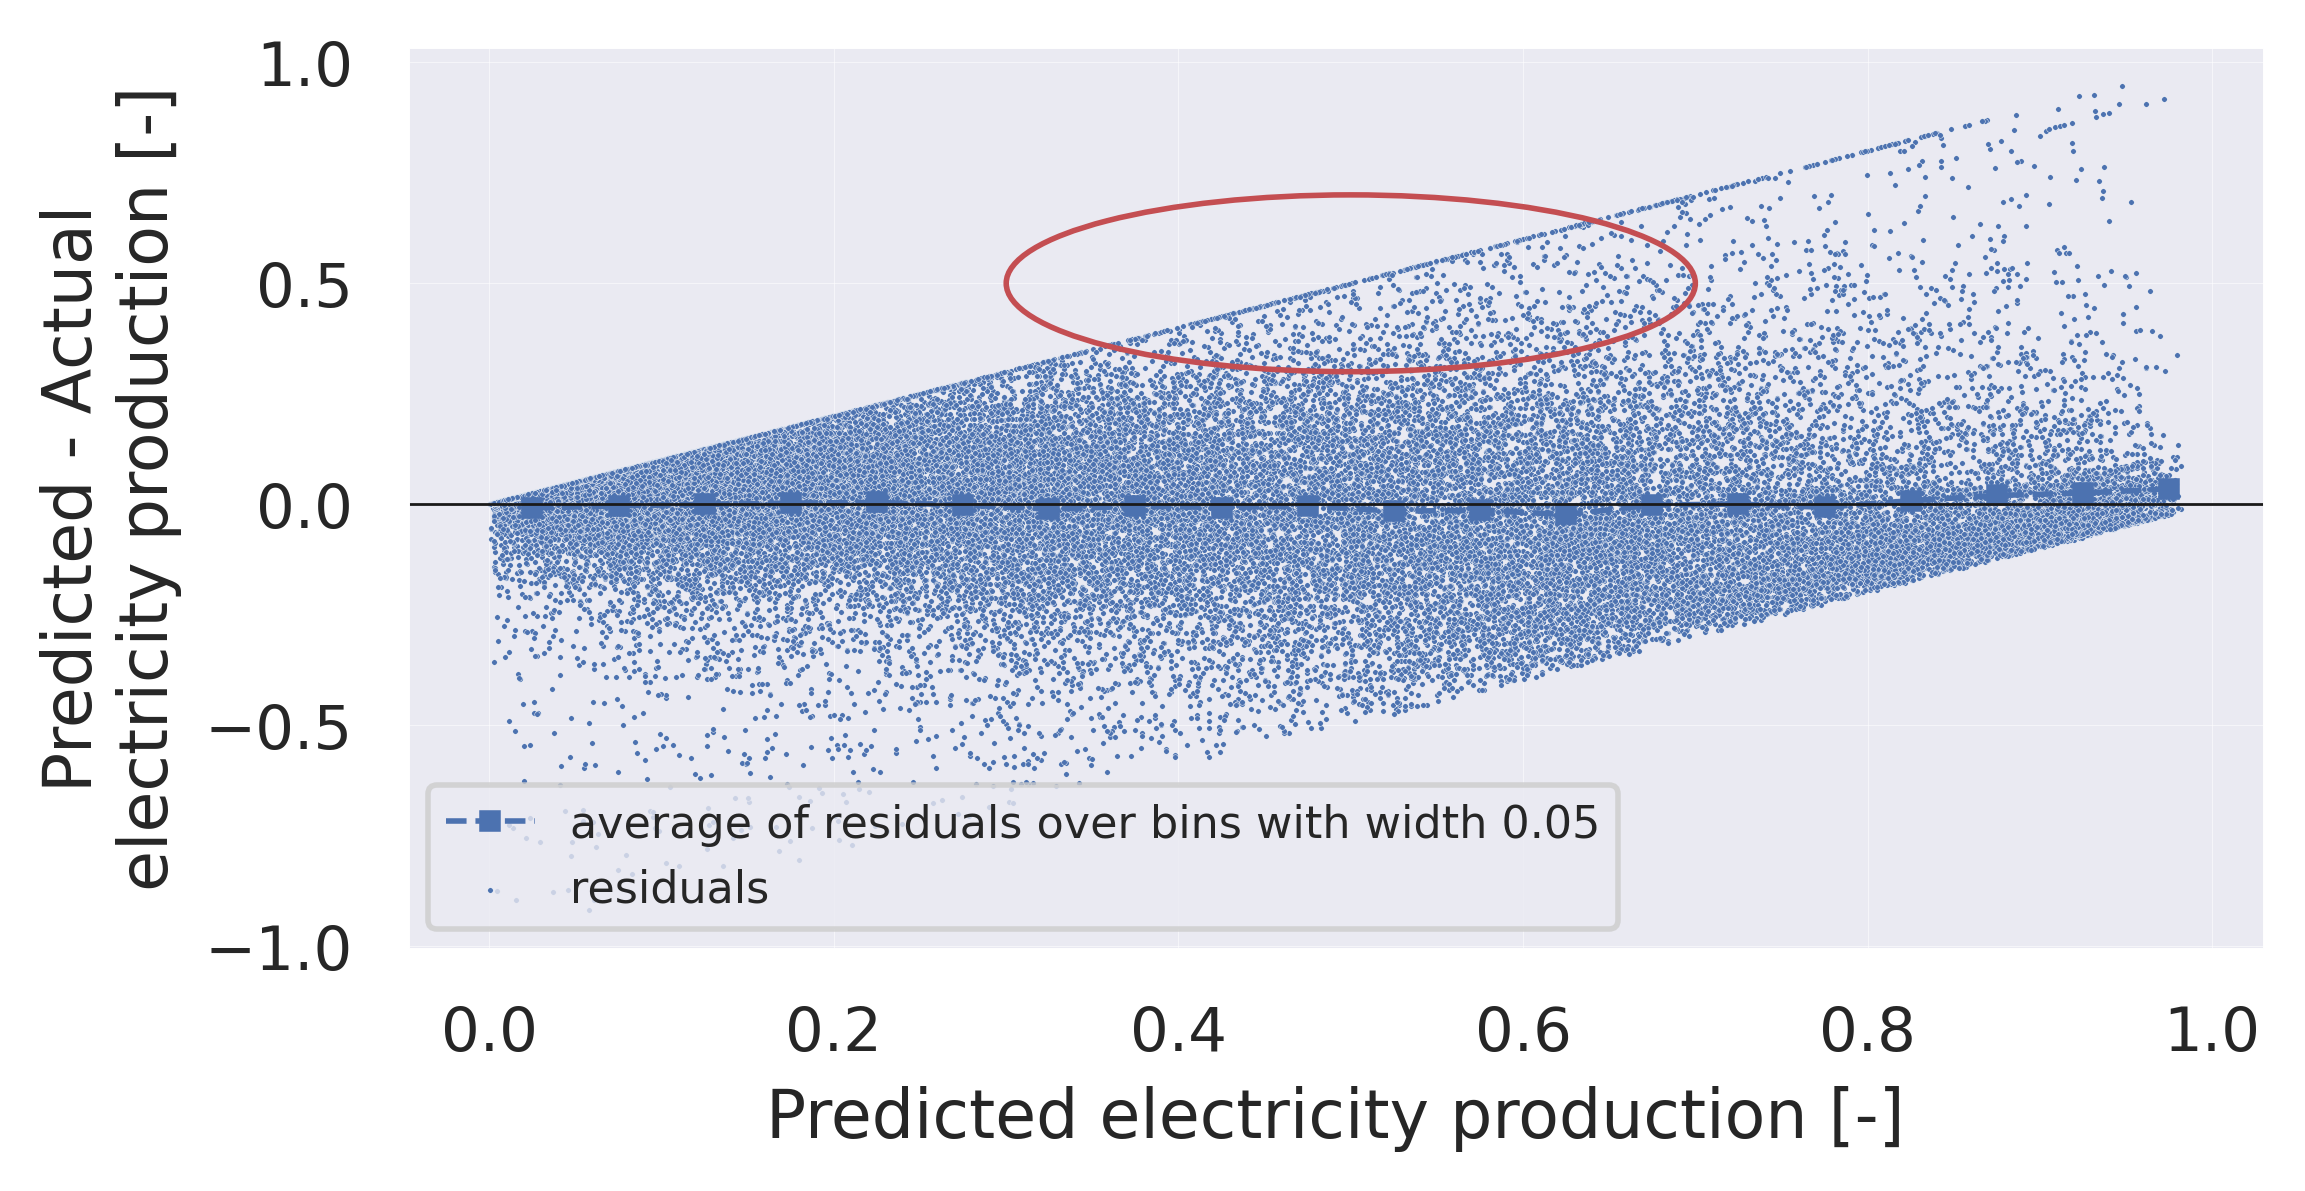

In [34]:
bias = df_results.groupby(by = 'PRED_BIN').mean()['RESIDUAL'] 
fig,ax = plt.subplots(dpi=400, figsize=(6,3))
ax.plot(np.arange(.025,1.00,.05), bias.values, linewidth=1, linestyle='--', marker='s', markersize=3, color='b', label='average of residuals over bins with width 0.05')
scatter = sns.scatterplot(data = df_results, x = 'PRED', y = 'RESIDUAL', s=1, label='residuals')
ax.grid(linewidth=.1)
ax.set_ylabel('Predicted - Actual\n electricity production [-]')
ax.set_xlabel('Predicted electricity production [-]')
ax.axhline(color = 'k', linewidth = 0.5)
circle1 = plt.Circle((.5, .5), 0.2, color='r', fill=False)
scatter.add_patch(circle1);

Predicting the zero values is a task for the future.